In [1]:
import yaml
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import matplotlib as mpl
from astropy import constants, units
from mpl_toolkits.axes_grid1 import make_axes_locatable


from scripts import *

plt.rcParams['font.size'] = 16
path = '/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc'
path = '/Users/arcticfox/Documents/disks'

In [2]:
def open_pickles(path):
    with open(os.path.join(path,'diskdata.pkl'), 'rb') as infile:
              diskinp = pickle.load(infile)
              ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze = diskinp
    return ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze

In [3]:
def plot_contour(data, cmap, ticks, ax, label, index=5, contourcolor=['k'], 
                 skipticks=0, logNorm=False, xlim=None, ylim=None, 
                 pressure=False, mu=2.3):
    
    cmap = mpl.cm.get_cmap(cmap)
    cmap.set_under('w')
    cmap.set_over(cmap(1.0))
    
    if pressure == False:
        dat = data[index] + 0.0
    else:
        dat = pressure_profile(data[4], data[5], mu=mu).value
    
    if logNorm == False:
        im = ax.pcolormesh(data[-2], data[-1], dat, cmap=cmap,
                           vmin=np.nanmin(ticks), vmax=np.nanmax(ticks))#,
                       #norm=mpl.colors.LogNorm(vmin=np.nanmin(ticks), vmax=np.nanmax(ticks)))
    else:
        im = ax.pcolormesh(data[-2], data[-1], dat, cmap=cmap,
                           norm=mpl.colors.LogNorm(vmin=np.nanmin(ticks), 
                                                   vmax=np.nanmax(ticks)))
        
    ax.contour(data[-2], data[-1], dat, ticks, colors=contourcolor)
    div = make_axes_locatable(ax)
    cax = div.append_axes('top', size='6%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=ticks[skipticks:])
    cbar.set_label(label, fontsize=16)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize = 14)
    
    ax.set_xlabel('R [AU]')
    
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    
    ax.set_rasterized(True)
    
    return

## RADMC model call

1.35
bigdisk


/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:49: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BuPu").copy()
  dcmap.set_under('w')
/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:50: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BuPu").copy()
  dcmap.set_over(dcmap(1.0))
/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:53: MatplotlibDeprecationWarning: You are modifying the state of a globa

plotted bigdisk summary figure


/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:128: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BuPu").copy()
  dcmap.set_under('w')
/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:129: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BuPu").copy()
  dcmap.set_over(dcmap(1.0))
/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:132: MatplotlibDeprecationWarning: You are modifying the state of a gl

plotted bigdisk summary figure


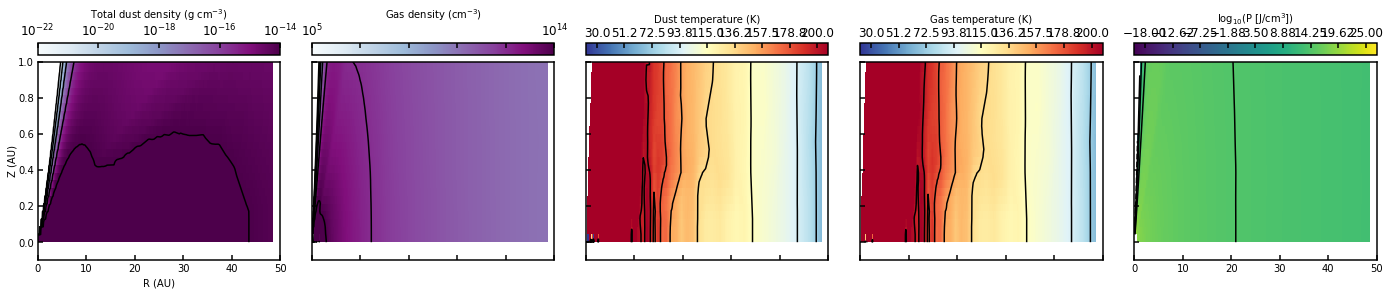

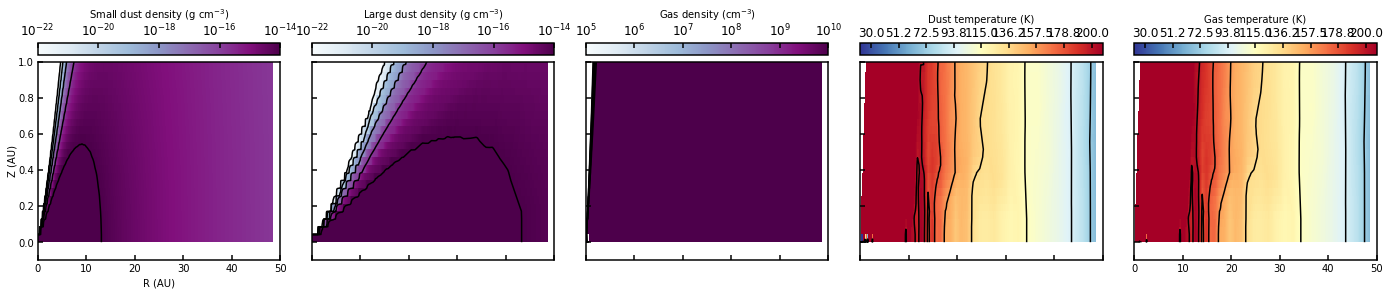

In [4]:
norm = setup(PATH=path, models=['bigdisk'], 
             uv=True, run=False, ndust=2,
             disk_params={'r_in':0.1, 'r_out':50.0, 'r_peb':50.0, 'r_snow':0.},
             grid_params={'ntheta':90, 
                          'nr':110, 
                          'n_in':0.05},
             star_params={'L_uv_star':6*10**2},
             disk_type='herbig', nphot=10**8)
            ## nr = 100; ntheta=96

In [9]:
bigdisk = open_pickles('/Users/arcticfox/Documents/disks/models/bigdisk')
f = np.nanmedian(bigdisk[3]+bigdisk[2])
new_hh = f**0.5
print(new_hh, f)

27.84703012258422 775.4570866481129


1.35
bigdisk100
plotted bigdisk100 summary figure
plotted bigdisk100 summary figure


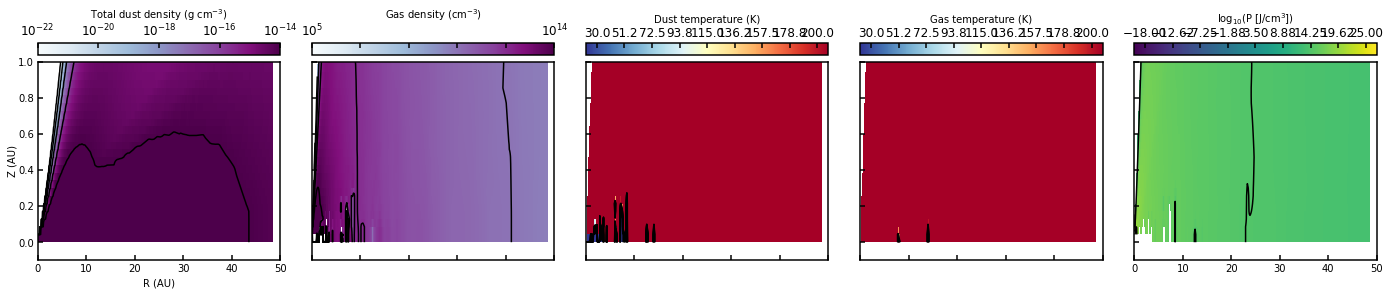

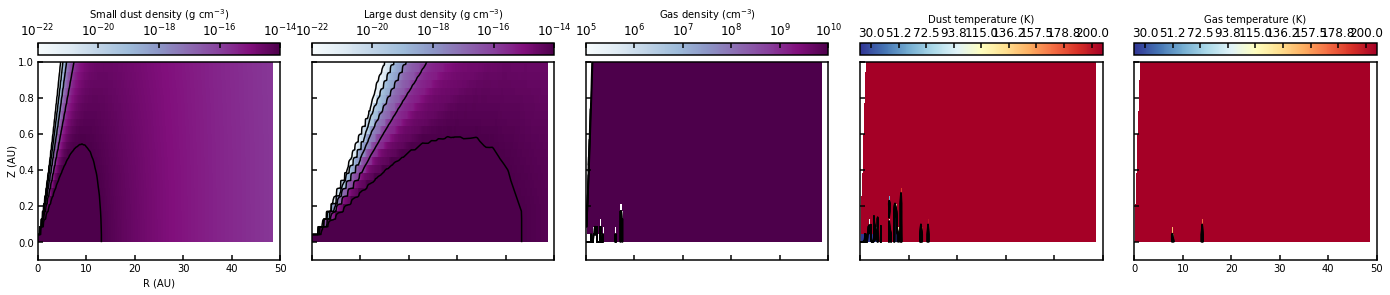

In [3]:
norm = setup(PATH=path, models=['bigdisk100'], 
             uv=True, run=False, ndust=2,
             disk_params={'r_in':0.1, 'r_out':50.0, 'r_peb':50.0, 'r_snow':0},
             grid_params={'ntheta':90, 
                          'nr':110, 
                          'n_in':0.05},
             star_params={'L_uv_star':6*10**4},
             disk_type='herbig', nphot=10**5.5)
            ## nr = 100; ntheta=96

In [7]:
bigdisk = open_pickles('/Users/arcticfox/Documents/disks/models/bigdisk')
bigdisk100 = open_pickles('/Users/arcticfox/Documents/disks/models/bigdisk100')       

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X a

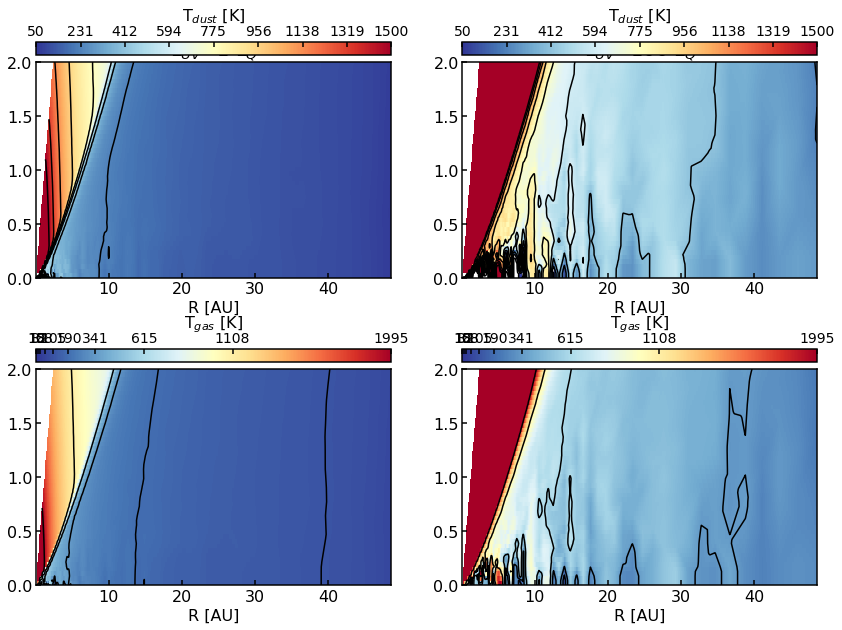

In [9]:
fig, ((ax1, ax2), (ax4, ax5)) = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

tdust_ticks = np.linspace(50,1500,9)
tgas_ticks = np.logspace(1,3.3, 10)

ylim=[0,2]

plot_contour(bigdisk, ticks=tdust_ticks, cmap='RdYlBu_r', ax=ax1,
                   label='T$_{dust}$ [K]', index=3, ylim=ylim)
ax1.set_title('L$_{UV}$=1 L$_Q$')

plot_contour(bigdisk100, ticks=tdust_ticks, cmap='RdYlBu_r', ax=ax2,
                   label='T$_{dust}$ [K]', index=3, ylim=ylim)
ax2.set_title('L$_{UV}$=100 L$_Q$')

plot_contour(bigdisk, ticks=tgas_ticks, cmap='RdYlBu_r', ax=ax4,
                   label='T$_{gas}$ [K]', index=5, ylim=ylim)
plot_contour(bigdisk100, ticks=tgas_ticks, cmap='RdYlBu_r', ax=ax5,
                   label='T$_{gas}$ [K]', index=5, ylim=ylim)
plt.subplots_adjust(hspace=0.3)

In [8]:
f = np.nanmedian((bigdisk100[3]+bigdisk100[2])/(bigdisk[3]+bigdisk[2]))
new_hh = f**0.5
print(new_hh)

1.704402806506473


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


1.704402806506473
bigdisk100_newhh
saved star spectrum
0.1 50.0
Saved radmc setup files in /Users/arcticfox/Documents/disks/models/bigdisk100_newhh
completed thermal mc
Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Saved gas disk data


/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:83: UserWarning: No contour levels were found within the data range.
  ax[ii].contour(re, ze, data, ticks, colors = ['k'])


plotted bigdisk100_newhh summary figure


/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:160: UserWarning: No contour levels were found within the data range.
  ax[ii].contour(re, ze, data, ticks, colors = ['k'])


plotted bigdisk100_newhh summary figure


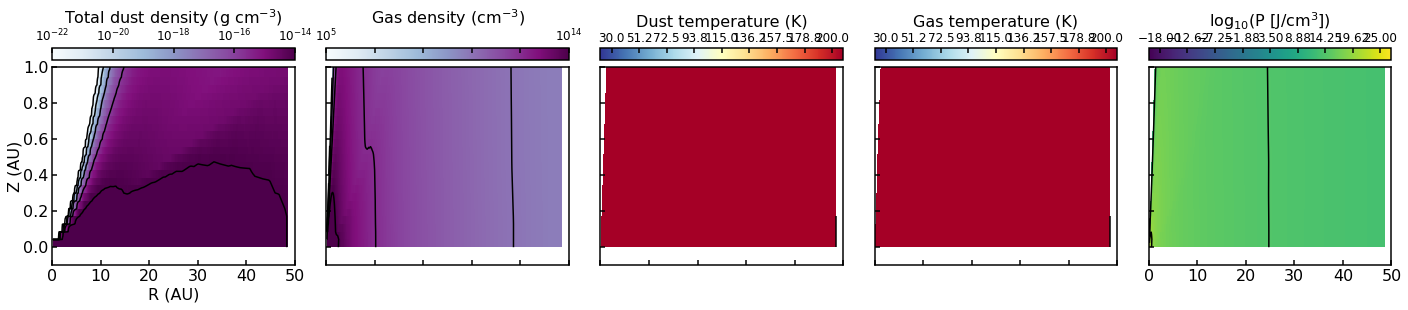

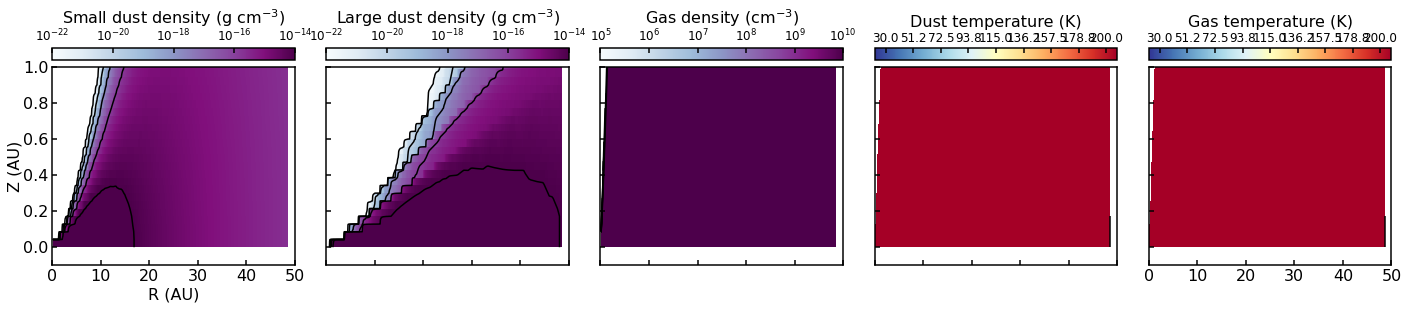

In [12]:
norm = setup(PATH=path, models=['bigdisk100_newhh'], 
             uv=True, run=True, ndust=2, hh=new_hh,
             disk_params={'r_in':0.1, 'r_out':50.0, 'r_peb':50.0, 'r_snow':0},
             grid_params={'ntheta':90, 
                          'nr':110, 
                          'n_in':0.05},
             star_params={'L_uv_star':6*10**4},
             disk_type='herbig', nphot=10**8)
            ## nr = 100; ntheta=96

In [14]:
new_bigdisk100 = open_pickles('/Users/arcticfox/Documents/disks/models/bigdisk100_newhh/')       

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X a

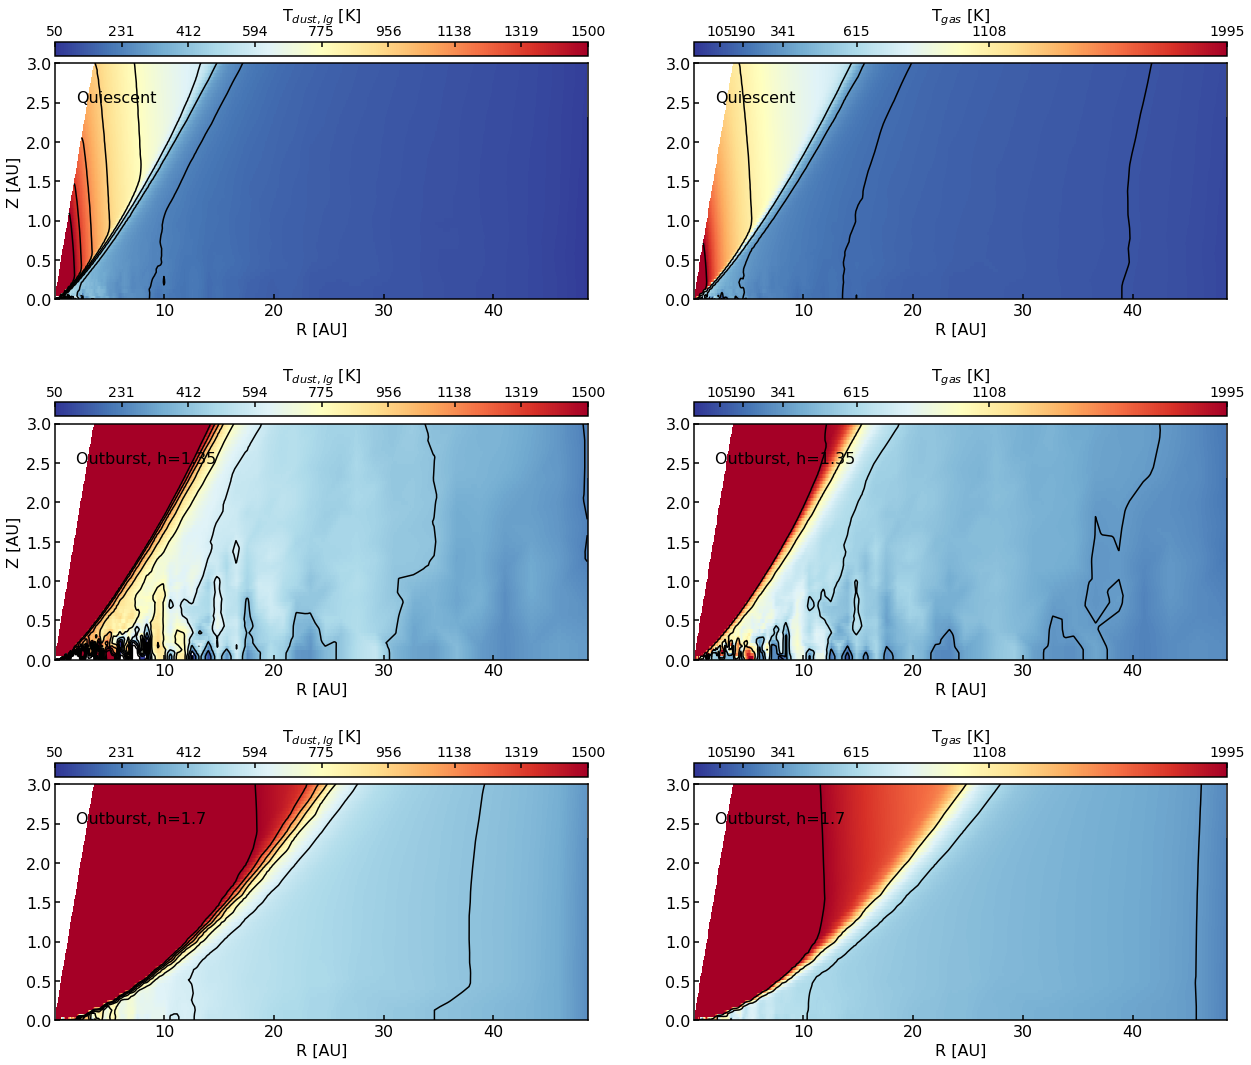

In [21]:
fig, ((ax4,ax5), (ax1,ax6), (ax2,ax3)) = plt.subplots(ncols=2, nrows=3, figsize=(21,18))
fig.set_facecolor('w')

ylim=[0,3]

plot_contour(bigdisk, 'RdYlBu_r', ticks=tdust_ticks, ax=ax4, label='T$_{dust, lg}$ [K]',
             index=3,ylim=ylim)
plot_contour(bigdisk100, 'RdYlBu_r', ticks=tdust_ticks, ax=ax1, label='T$_{dust, lg}$ [K]',
             index=3,ylim=ylim)
plot_contour(new_bigdisk100, 'RdYlBu_r', ticks=tdust_ticks, ax=ax2, label='T$_{dust, lg}$ [K]',
             index=3,ylim=ylim)

plot_contour(bigdisk, 'RdYlBu_r', ticks=tgas_ticks, ax=ax5, label='T$_{gas}$ [K]', 
             skipticks=4,ylim=ylim)
plot_contour(bigdisk100, 'RdYlBu_r', ticks=tgas_ticks, ax=ax6, label='T$_{gas}$ [K]', 
             skipticks=4,ylim=ylim)
plot_contour(new_bigdisk100, 'RdYlBu_r', ticks=tgas_ticks, ax=ax3, label='T$_{gas}$ [K]', 
             skipticks=4,ylim=ylim)

ax1.set_ylabel('Z [AU]')
ax4.set_ylabel('Z [AU]')
plt.subplots_adjust(hspace=0.4)

labels = ['Quiescent', 'Outburst, h=1.35', 'Outburst, h={}'.format(np.round(new_hh,2))]
ax_sets = [[ax4, ax5], [ax1,ax6], [ax2,ax3]]
for i in range(len(labels)):
    ax_sets[i][0].text(s=labels[i], x=2, y=2.5, fontsize=16)
    ax_sets[i][1].text(s=labels[i], x=2, y=2.5, fontsize=16)
plt.savefig('/Users/arcticfox/Documents/GitHub/disks_and_outbursts/figures/comparison_midplane.png', 
            rasterize=True, bbox_inches='tight', dpi=300)

### output order = ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and

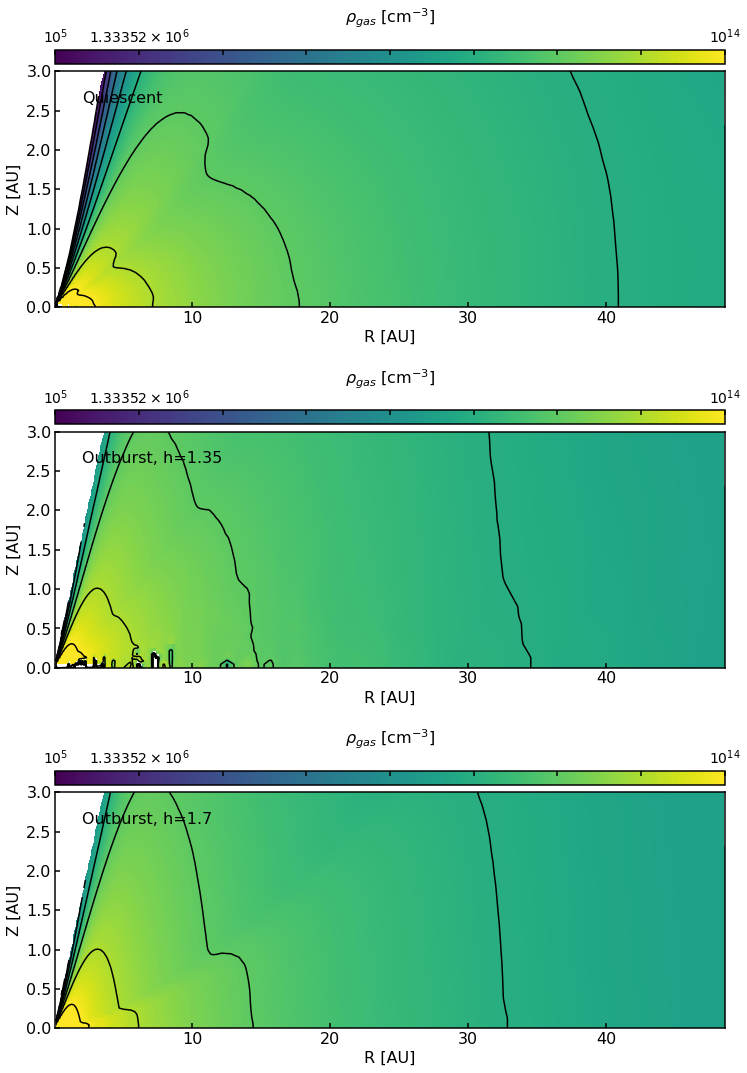

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12,18))
fig.set_facecolor('w')

dgas_ticks = np.logspace(5,14,9)

plot_contour(bigdisk, 'viridis', ticks=dgas_ticks, ax=ax1, label=r'$\rho_{gas}$ [cm$^{-3}$]',
             index=4, logNorm=True,ylim=ylim)
plot_contour(bigdisk100, 'viridis', ticks=dgas_ticks, ax=ax2, label=r'$\rho_{gas}$ [cm$^{-3}$]',
             index=4, logNorm=True,ylim=ylim)
plot_contour(new_bigdisk100, 'viridis', ticks=dgas_ticks, ax=ax3, 
             label=r'$\rho_{gas}$ [cm$^{-3}$]',
             index=4, logNorm=True,ylim=ylim)

ax1.set_ylabel('Z [AU]')
ax2.set_ylabel('Z [AU]')
ax3.set_ylabel('Z [AU]')
plt.subplots_adjust(hspace=0.4)

labels = ['Quiescent', 'Outburst, h=1.35', 'Outburst, h={}'.format(np.round(new_hh,2))]
ax_sets = [ax1, ax2, ax3]
for i in range(len(labels)):
    ax_sets[i].text(s=labels[i], x=2, y=2.6, fontsize=16)
#plt.savefig('/Users/arcticfox/Documents/GitHub/disks_and_outbursts/figures/comparison_density.png', 
#            rasterize=True, bbox_inches='tight', dpi=300)

## Pressure Profiles

In [55]:
def pressure_profile(rho, T, mu=2.3):
    rho = rho * units.g / units.cm**3
    T = T * units.K
    
    kB = 1.3806*10**-23 * units.Joule / units.K
    mH = 1.67*10**-24 * units.g
    
    cs = (kB * T) / (mu * mH)
    P = rho * cs
    return P.to(units.Joule/units.cm**3)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals wit

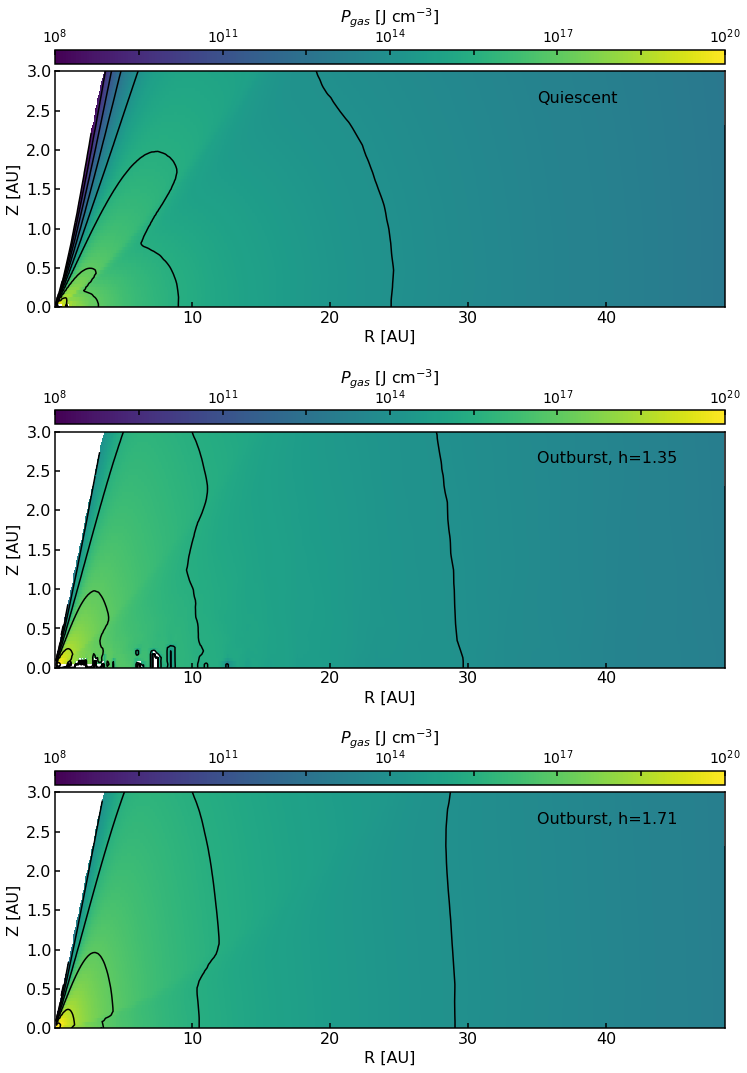

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12,18))
fig.set_facecolor('w')

p_ticks = 10**np.linspace(8,20,9)

plot_contour(bigdisk, 'viridis', ticks=p_ticks, ax=ax1, label=r'$P_{gas}$ [J cm$^{-3}$]',
             logNorm=True,ylim=ylim,pressure=True)
plot_contour(bigdisk100, 'viridis', ticks=p_ticks, ax=ax2, label=r'$P_{gas}$ [J cm$^{-3}$]',
             logNorm=True,ylim=ylim,pressure=True)
plot_contour(new_bigdisk100, 'viridis', ticks=p_ticks, ax=ax3, 
             label=r'$P_{gas}$ [J cm$^{-3}$]',
             logNorm=True,ylim=ylim, pressure=True)

ax1.set_ylabel('Z [AU]')
ax2.set_ylabel('Z [AU]')
ax3.set_ylabel('Z [AU]')
plt.subplots_adjust(hspace=0.4)

labels = ['Quiescent', 'Outburst, h=1.35', 'Outburst, h={}'.format(np.round(new_hh,2))]
ax_sets = [ax1, ax2, ax3]
for i in range(len(labels)):
    ax_sets[i].text(s=labels[i], x=35, y=2.6, fontsize=16)
plt.savefig('/Users/arcticfox/Documents/GitHub/disks_and_outbursts/figures/pressure_profile.png', 
            rasterize=True, bbox_inches='tight', dpi=300)

## Increase stellar luminosity & UV component

$\frac{L}{L_B} \propto \frac{T^4}{T_B^4}$

$T \propto \left( \frac{100 L_B}{L_B}*T_B^4 \right)^{1/4}$

In [86]:
(100*6000**4)**0.25

18973.665961010276

1.35
lstar_test
saved star spectrum
cell centers :  [ 0.05162029  0.05496587  0.05852829  0.0623216   0.06636076  0.0706617
  0.07524138  0.08011789  0.08531045  0.09083955  0.09672699  0.10299601
  0.10967134  0.1167793   0.12434794  0.13240712  0.14098862  0.1501263
  0.15985621  0.17021673  0.18124873  0.19299572  0.20550406  0.21882309
  0.23300534  0.24810676  0.26418693  0.28130928  0.29954135  0.31895507
  0.33962702  0.36163875  0.3850771   0.41003452  0.43660946  0.46490677
  0.49503807  0.52712222  0.5612858   0.59766356  0.63639903  0.67764499
  0.72156417  0.76832982  0.81812642  0.87115041  0.92761096  0.9877308
  1.0517471   1.1199124   1.19249558  1.269783    1.35207952  1.4397098
  1.53301953  1.63237681  1.73817358  1.85082719  1.97078205  2.09851136
  2.234519    2.3793415   2.53355016  2.69775331  2.87259871  3.05877611
  3.25701993  3.46811223  3.69288574  3.93222715  4.18708064  4.45845156
  4.74741043  5.05509716  5.38272552  5.73158796  6.10306069  6.49860913
  6

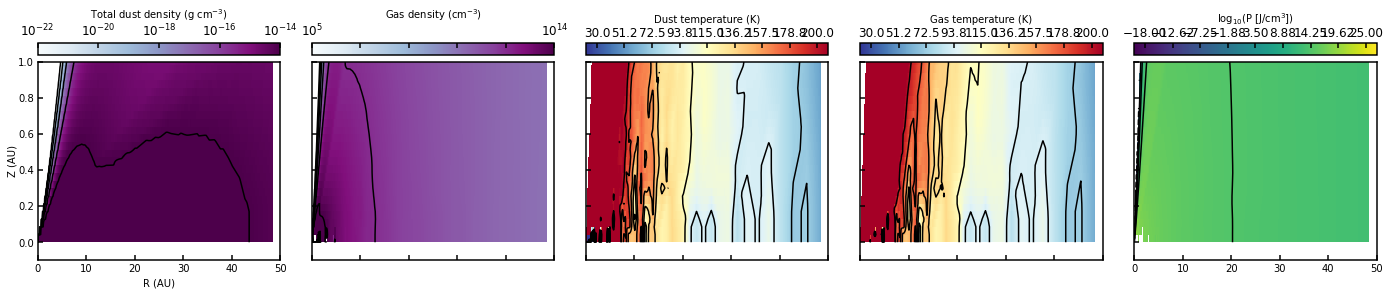

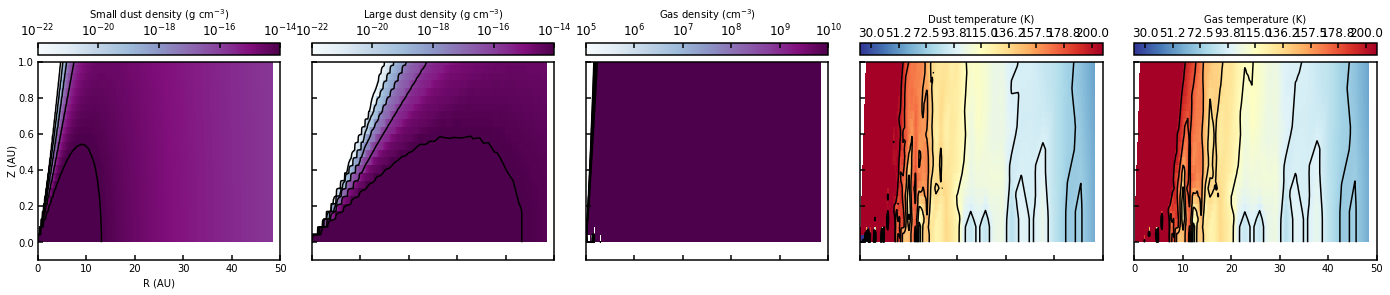

In [11]:
norm = setup(PATH=path, models=['lstar_test'], 
             uv=False, run=True, ndust=2, #hh=new_hh,
             disk_params={'r_in':0.1, 'r_out':50.0, 'r_peb':50.0, 'r_snow':0.1},
             grid_params={'ntheta':90, 
                          'nr':110, 
                          'n_in':0.05},
             star_params={'L_star':6*200,
                          'T_star':15000},
             disk_type='herbig', nphot=10**6)
            ## nr = 100; ntheta=96

In [7]:
bigdisk100_L = open_pickles('/Users/arcticfox/Documents/disks/models/bigdisk100_lum')       
f = np.nanmedian((bigdisk100_L[3]+bigdisk100_L[2])/(bigdisk[3]+bigdisk[2]))
new_hh = f**0.5
print(f, new_hh)

NameError: name 'bigdisk' is not defined

1.7094804696254087
bigdisk100_lum
saved star spectrum
0.1 50.0
Saved radmc setup files in /Users/arcticfox/Documents/disks/models/bigdisk100_lum
completed thermal mc
Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Saved gas disk data


/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:83: UserWarning: No contour levels were found within the data range.
  ax[ii].contour(re, ze, data, ticks, colors = ['k'])


plotted bigdisk100_lum summary figure


/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/scripts/plot_summary.py:160: UserWarning: No contour levels were found within the data range.
  ax[ii].contour(re, ze, data, ticks, colors = ['k'])


plotted bigdisk100_lum summary figure


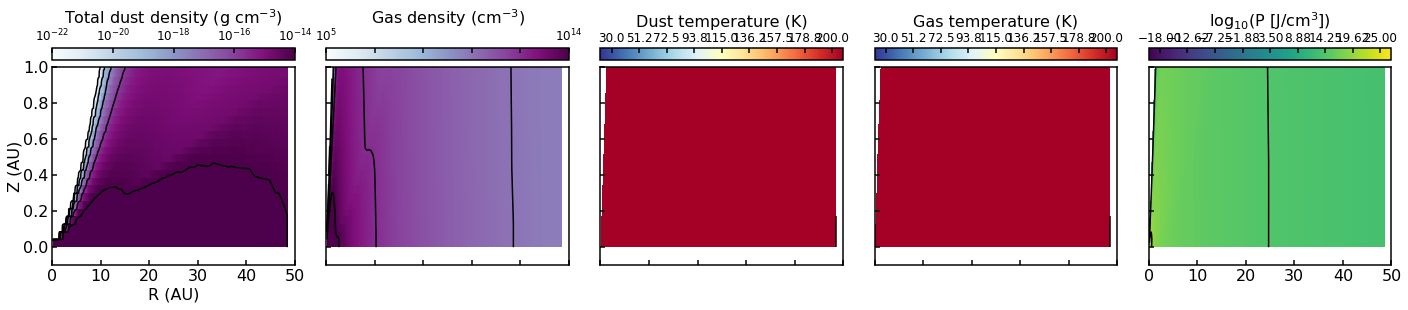

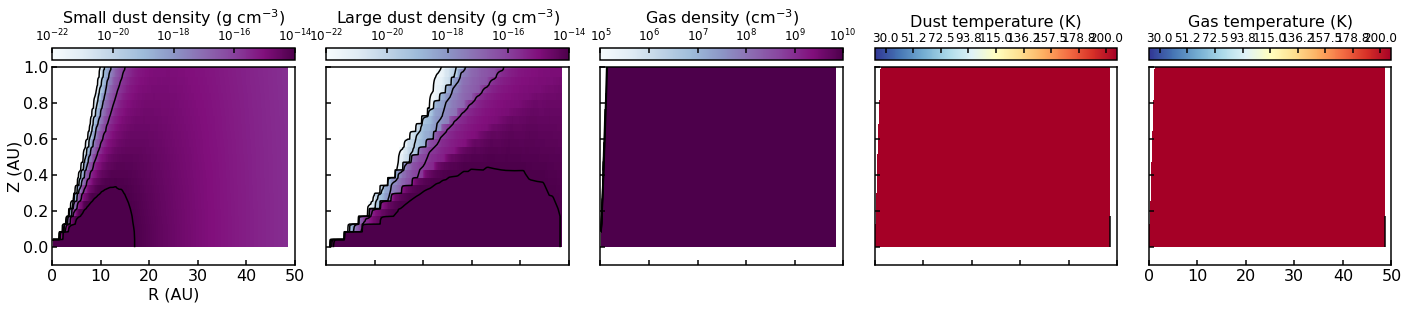

In [89]:
norm = setup(PATH=path, models=['bigdisk100_lum'], 
             uv=True, run=True, ndust=2, hh=new_hh,
             disk_params={'r_in':0.1, 'r_out':50.0, 'r_peb':50.0, 'r_snow':0},
             grid_params={'ntheta':90, 
                          'nr':110, 
                          'n_in':0.05},
             star_params={'L_uv_star':6*10**4,
                          'T_star':(100*6000**4)**(0.25)},
             disk_type='herbig', nphot=10**8)
            ## nr = 100; ntheta=96

In [10]:
bigdisk100_L = open_pickles('/Users/arcticfox/Documents/disks/models/bigdisk100_lum')   
just_l = open_pickles('/Users/arcticfox/Documents/disks/models/lstar_test/')

NameError: name 'tdust_ticks' is not defined

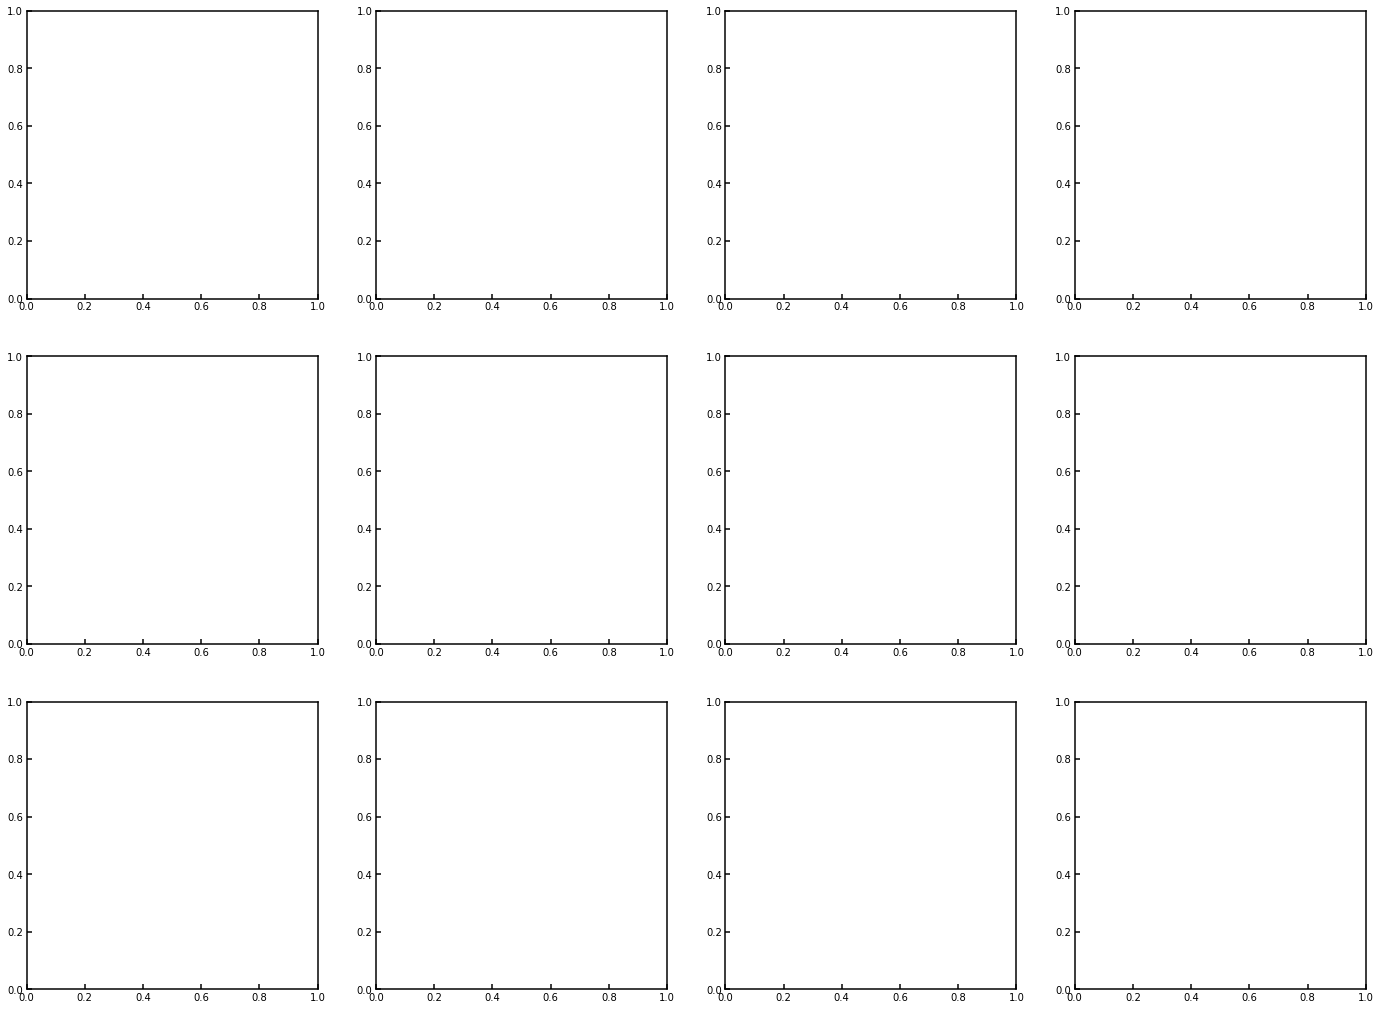

In [11]:
fig, ((ax1,ax2, ax3, ax0), (ax4,ax5, ax6, ax10), (ax7,ax8,ax9, ax11)) = plt.subplots(ncols=4, 
                                                                    nrows=3, figsize=(24,18))
fig.set_facecolor('w')

ylim=[0,30]
y=25
x=2

plot_contour(bigdisk, 'RdYlBu_r', ticks=tdust_ticks, ax=ax1, label='T$_{dust, lg}$ [K]',
             index=3,ylim=ylim)
plot_contour(new_bigdisk100, 'RdYlBu_r', ticks=tdust_ticks, ax=ax4, label='T$_{dust, lg}$ [K]',
             index=3,ylim=ylim)
plot_contour(bigdisk100_L, 'RdYlBu_r', ticks=tgas_ticks, ax=ax7, label='T$_{gas}$ [K]', 
             skipticks=4,ylim=ylim)

plot_contour(bigdisk, 'RdYlBu_r', ticks=tgas_ticks, ax=ax2, label='T$_{gas}$ [K]', 
             skipticks=4,ylim=ylim)
plot_contour(new_bigdisk100, 'RdYlBu_r', ticks=tgas_ticks, ax=ax5, label='T$_{gas}$ [K]', 
             skipticks=4,ylim=ylim)
plot_contour(bigdisk100_L, 'RdYlBu_r', ticks=tgas_ticks, ax=ax8, label='T$_{gas}$ [K]', 
             skipticks=4,ylim=ylim)

plot_contour(bigdisk, 'viridis', ticks=p_ticks, ax=ax3, label=r'$P_{gas}$ [J cm$^{-3}$]',
             logNorm=True,ylim=ylim,pressure=True)
plot_contour(new_bigdisk100, 'viridis', ticks=p_ticks, ax=ax6, label=r'$P_{gas}$ [J cm$^{-3}$]',
             logNorm=True,ylim=ylim,pressure=True)
plot_contour(bigdisk100_L, 'viridis', ticks=p_ticks, ax=ax9, label=r'$P_{gas}$ [J cm$^{-3}$]',
             logNorm=True,ylim=ylim,pressure=True)

plot_contour(bigdisk, 'plasma', ticks=dgas_ticks, ax=ax0, label=r'$\rho_{gas}$ [cm$^{-3}$]',
             index=4, logNorm=True,ylim=ylim)
plot_contour(new_bigdisk100, 'plasma', ticks=dgas_ticks, ax=ax10, label=r'$\rho_{gas}$ [cm$^{-3}$]',
             index=4, logNorm=True,ylim=ylim)
plot_contour(bigdisk100_L, 'plasma', ticks=dgas_ticks, ax=ax11, 
             label=r'$\rho_{gas}$ [cm$^{-3}$]',
             index=4, logNorm=True,ylim=ylim)

ax1.set_ylabel('Z [AU]')
ax4.set_ylabel('Z [AU]')
plt.subplots_adjust(hspace=0.4)

labels = ['Quiescent', 'UV Outburst', 'UV + L Outburst']
ax_sets = [[ax1, ax2, ax3, ax0], [ax4,ax5,ax6, ax10], [ax7,ax8,ax9, ax11]]
for i in range(len(labels)):
    for ax in ax_sets[i]:
        ax.text(s=labels[i], x=x, y=y, fontsize=16)
#plt.savefig('/Users/arcticfox/Documents/GitHub/disks_and_outbursts/figures/comparison_fullpic.png', 
#            rasterize=True, bbox_inches='tight', dpi=300)